In [1277]:
import pandas
import numpy as np

#Read data

In [1301]:
train = pandas.read_csv('data/train.csv')
test = pandas.read_csv('data/test.csv')

#Парсим дату
train['datetime'] = pandas.to_datetime(train['datetime'])
#Делаем дату индексом талбицы, чтобы удобно работать с временными рядами
train = train.set_index('datetime').sort_index()

test['datetime'] = pandas.to_datetime(test['datetime'])
test = test.set_index('datetime').sort_index()

#Feature generation

In [1279]:
#Генерируем признак часа, при этом часы переупорядочиваются в порядке возрастания кол-ва орендованных велосипедов.
#Осталось от линейной регрессии. Там этот подход улучшал решение.
def hour(date):
    h_map = [4, 5, 3, 6, 2, 1, 0, 7, 23, 8, 22, 21, 9, 20, 10, 19, 11, 18, 12, 13, 16, 17, 15, 14]
    return h_map.index(date.hour) + 1

#Получаем месяц из даты
def month(date):
    return date.month

#Переупорядочиваем месяцы аналогично часам. В решении не используется.
def month_reoder(month):
    m_map = [1, 2, 12, 3, 11, 10, 4, 5, 8, 9, 6, 7]
    return m_map.index(month) + 1

#Генерируем бинарный признак, необходимый для разделения данных по годам. 
def is2012(date):
    return float(date.year == 2012)

#Получаем день недели из даты
def weekday(date):
    return float(date.weekday())

train['hour'] = train.index.to_series().apply(hour)
train['month'] = train.index.to_series().apply(month)
train['month_reorder'] = train['month'].apply(month_reoder)
train['is2012'] = train.index.to_series().apply(is2012)
train['day_number'] = (train.index.to_series() - train.index.to_series()[0]).apply(int)
train['weekday'] = train.index.to_series().apply(weekday)

test['hour'] = test.index.to_series().apply(hour)
test['month'] = test.index.to_series().apply(month)
test['month_reorder'] = test['month'].apply(month_reoder)
test['is2012'] = test.index.to_series().apply(is2012)
test['day_number'] = (test.index.to_series() - test.index.to_series()[0]).apply(int)
test['weekday'] = test.index.to_series().apply(weekday)

coeff_2012 = train[train['is2012'] == 1]['casual'].mean() / train[train['is2012'] == 0]['casual'].mean() * 0.75

#Training set

In [1280]:
#Для удобства вводим временные ряды целывых признаков
casual_time_series = pandas.TimeSeries(train['casual'])
registered_time_series = pandas.TimeSeries(train['registered'])
count_time_series = pandas.TimeSeries(train['count'])

In [1281]:
#Формируем обучающую выборку
y = casual_time_series
features = ['weather', 'hour', 'workingday', 'temp', 'is2012']
X = train[features]
X_test = test[features]

In [1282]:
#Нормируем выборку. Это улучшает решение методом Knn
X['isTest'] = 0
X_test['isTest'] = 1

X_gen = X.append(X_test)
X_gen = (X_gen - X_gen.mean()) / (X_gen.max() - X_gen.min())

X = X_gen[X_gen['isTest'] < 0]
X_test = X_gen[X_gen['isTest'] >= 0]

X = X.drop('isTest', 1)
X_test = X_test.drop('isTest', 1)

#Machine learning

In [1283]:
from sklearn import neighbors
from sklearn.base import BaseEstimator

In [1284]:
#Создаем собственный классификатор на основе Knn, который может отдельно масштабировать ответ для 2011 и 2012 годов
class ScaledKnn(BaseEstimator):
    def __init__(self, coeff_2011, coeff_2012):
        self.coeff_2012 = coeff_2012
        self.coeff_2011 = coeff_2011
        self.knn = neighbors.KNeighborsRegressor(10, p=1)
    
    def fit(self, X, y):
        self.knn.fit(X.drop('is2012', 1), y)            
        return self
        
    def predict(self, X):
        y_ = self.knn.predict(X.drop('is2012', 1))                    
        y_ = pandas.Series(y_, index = X.index)
        y_[X['is2012'] >= 0] *= self.coeff_2012
        y_[X['is2012'] < 0] *= self.coeff_2011
        return y_

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold 

In [ ]:
def RMLSE(clf, X, y_true):
    y_pred = clf.predict(X)
    y_pred[y_pred < 0] = 0
    temp = (np.log(y_pred + 1) - np.log(y_true + 1))**2
    n = temp.shape[0]
    
    temp = temp.sum()/n
    
    return temp**0.5

#Grid search

In [ ]:
#Подбираем коэффициенты для  нашего классификатора
# coeff_ = np.linspace(0.7, 1.3, 20)
# best_score = 100
# best_c_2011 = coeff_[0]
# best_c_2012 = coeff_[0]
# for c_2011 in coeff_:
#     for c_2012 in coeff_:
#         scores = []
#         kf = KFold(len(X), n_folds=5, shuffle=True)
#         for train_index, test_index in kf:
#             cv_x = X.iloc[train_index]
#             cv_y = y.iloc[train_index]

#             cv_x_test = X.iloc[test_index]
#             cv_y_test = y.iloc[test_index]

#             model = ScaledKnn(c_2011, c_2012)
#             cv_model = model.fit(cv_x, cv_y)

#             scores.append(RMLSE(cv_model, cv_x_test, cv_y_test))

#         scores = np.array(scores)
            
#         if best_score > scores.mean():
#             best_score = scores.mean()
#             best_c_2011 = c_2011
#             best_c_2012 = c_2012
        
#     print c_2011
        
# print "mean: ", best_score, ";", best_c_2011, ";", best_c_2012

#Casual prediction

In [1285]:
knn = ScaledKnn(0.731578947368, 0.952631578947)
y_ = knn.fit(X, y).predict(X_test)

In [1286]:
test['casual'] = y_
predicted_casual_time_series_knn = pandas.TimeSeries(test['casual'])

In [1287]:
from matplotlib import pyplot as plt
%matplotlib inline

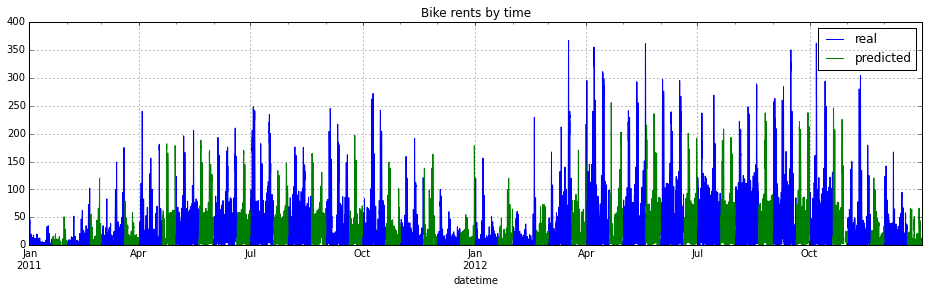

In [1288]:
plt.figure(figsize=(16, 4))
casual_time_series.resample('h').plot()
predicted_casual_time_series_knn.resample('h').plot()
plt.title('Bike rents by time')
plt.legend(['real', 'predicted'])
plt.show()

#Registered prediction
Все что ниже взято из предыдущего удачного решения, и мне лень расписывать.

In [1293]:
class RegCasualRF(BaseEstimator):
    
    def __init__(self, RF_registered_2011, RF_registered_2012):
        self.RF_registered_2011 = RF_registered_2011
        self.RF_registered_2012 = RF_registered_2012        
        
    def fit(self, X, y):
        self.RF_registered_2011.fit(X[X['is2012'] == 0], y[X['is2012'] == 0])
        self.RF_registered_2012.fit(X[X['is2012'] == 1], y[X['is2012'] == 1])
        return self
    
    def predict(self, X):
        y_2011 = self.RF_registered_2011.predict(X[X['is2012'] == 0])
        y_2011 = pandas.TimeSeries(y_2011, index = X[X['is2012'] == 0].index)
        
              
        y_2012 = self.RF_registered_2012.predict(X[X['is2012'] == 1])
        y_2012 = pandas.TimeSeries(y_2012, index = X[X['is2012'] == 1].index)
        return y_2011.append(y_2012)

In [1294]:
clf = RegCasualRF(RandomForestRegressor(n_estimators = 1000, min_samples_split=7, oob_score = True),
                  RandomForestRegressor(n_estimators = 1000, min_samples_split=7, oob_score = True))

In [1295]:
y = registered_time_series
features = ['weather', 'hour', 'workingday', 'temp', 'is2012', 'season', 'holiday', 'weekday']
X = train[features]
X_test = test[features]

In [1296]:
y_ = clf.fit(X, y).predict(X_test)
test['registered'] = y_
predicted_registered_time_series = pandas.TimeSeries(test['registered'])

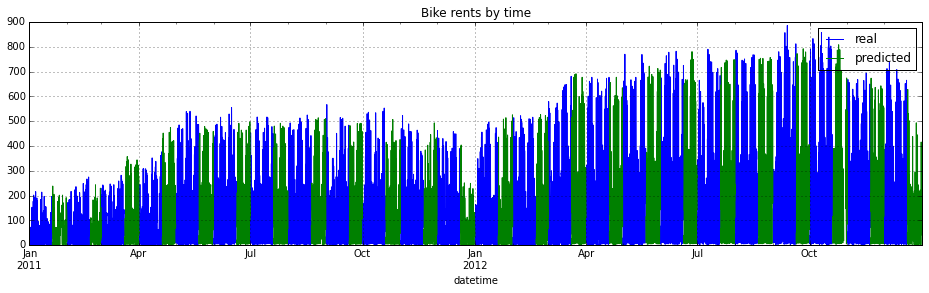

In [1297]:
plt.figure(figsize=(16, 4))
registered_time_series.resample('h').plot()
predicted_registered_time_series.resample('h').plot()
plt.title('Bike rents by time')
plt.legend(['real', 'predicted'])
plt.show()

In [1298]:
predicted_count_time_series = predicted_registered_time_series + predicted_casual_time_series_knn

In [1299]:
predicted_count_time_series.to_csv('result.csv')